In [1]:
import gym
import numpy as np
import torch
from sac_agent import soft_actor_critic_agent
from replay_memory import ReplayMemory

seed=0  
env = gym.make('BipedalWalker-v2')
torch.manual_seed(seed)
np.random.seed(seed)
env.seed(seed)

batch_size=256
num_steps = 1e7  # maximum number of steps = 1e7, it was = 1e6

LEARNING_RATE=0.0001
eval=True  ## 
start_steps=10000 ## Steps sampling random actions
replay_size=1000000 ## size of replay buffer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# alpha=0.2  # relative importance of the entropy
# gamma=0.99  # discount factor 
# tau=0.005  # target smoothing coefficient(τ)

agent = soft_actor_critic_agent(env.observation_space.shape[0], env.action_space, \
        device=device, hidden_size=256, lr=LEARNING_RATE, gamma=0.99, tau=0.005, alpha=0.2)

memory = ReplayMemory(replay_size)

print('device: ', device)
print('state dim: ', env.observation_space.shape[0])
print('action dim: ', env.action_space)
print('leraning rate: ', LEARNING_RATE)

device:  cuda:0
state dim:  24
action dim:  Box(4,)
leraning rate:  0.0001


In [2]:
def save(agent, directory, filename, suffix):
    torch.save(agent.policy.state_dict(), '%s/%s_actor_%s.pth' % (directory, filename, suffix))
    torch.save(agent.critic.state_dict(), '%s/%s_critic_%s.pth' % (directory, filename, suffix))
    
limits = [-300, -160, -100, -70, -50, 0, 20, 30, 40, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]

def return_suffix(j):
    suf = '0'
    for i in range(len(limits)-1):
        if j > limits[i] and j < limits[i+1]:
            suf = str(limits[i+1])
            break
        
        i_last = len(limits)-1    
        if  j > limits[i_last]:
            suf = str(limits[i_last])
            break
    return suf       

In [3]:
import time
from  collections  import deque

def sac_train():

    total_numsteps = 0
    updates = 0
    num_episodes = 10001

    time_start = time.time()
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = [] 
    
    for i_episode in range(num_episodes): 
        episode_reward = 0
        episode_steps = 0
        done = False
        state = env.reset()

        avg_reward = 0
        
        while not done:
            if start_steps > total_numsteps:
                action = env.action_space.sample()  # Sample random action
            else:
                action = agent.select_action(state)  # Sample action from policy

            if len(memory) > batch_size:
                
                # Update parameters of all the networks
                critic_1_loss, critic_2_loss, policy_loss, ent_loss, alpha = \
                       agent.update_parameters(memory, batch_size, updates)

                updates += 1

            next_state, reward, done, _ = env.step(action) # Step
            episode_steps += 1
            total_numsteps += 1
            episode_reward += reward

            # Ignore the "done" signal if it comes from hitting the time horizon.
            # (https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py)
            mask = 1 if episode_steps == env._max_episode_steps else float(not done)

            memory.push(state, action, reward, next_state, mask) # Append transition to memory

            state = next_state

            if i_episode % 10 == 0 and i_episode > 0 and eval == True:
                avg_reward = 0.
                episodes = 10
                
                
                for _  in range(episodes):
                    state = env.reset()
                    test_total_reward = 0
                    done = False
                    
                    while not done:
                        action = agent.select_action(state, eval=True)

                        next_state, reward, done, _ = env.step(action)
                        test_total_reward += reward
 

                        state = next_state
    
                    avg_reward += test_total_reward
                avg_reward /= episodes

                print("*** Test Episodes: {}, Reward: {:.2f}, Avg. Reward: {:.2f}".\
                      format(episodes, test_total_reward, avg_reward))
                
                scores_deque.append(test_total_reward)
                scores_array.append(test_total_reward)        
                avg_score = np.mean(scores_deque)
                avg_scores_array.append(avg_score)
        
        if i_episode % 100 == 0 and i_episode > 0:
            suf = return_suffix(avg_score)
            save(agent, 'dir_chk', 'weights', suf)

        s =  (int)(time.time() - time_start)
            
        print("Ep.: {}, Total Steps: {}, Ep.Steps: {}, Score: {:.2f},  Time: {:02}:{:02}:{:02}".\
            format(i_episode, total_numsteps, episode_steps, episode_reward, \
                  s//3600, s%3600//60, s%60))

                    
        if (avg_reward > 300.5):
            print('Solved environment with Avg Score:  ', avg_reward)
            break;
            
    return scores_array, avg_scores_array 

scores, avg_scores = sac_train()

Ep.: 0, Total Steps: 60, Ep.Steps: 60, Score: -109.17,  Time: 00:00:00
Ep.: 1, Total Steps: 135, Ep.Steps: 75, Score: -99.25,  Time: 00:00:00
Ep.: 2, Total Steps: 215, Ep.Steps: 80, Score: -117.54,  Time: 00:00:00
Ep.: 3, Total Steps: 1815, Ep.Steps: 1600, Score: -75.72,  Time: 00:01:28
Ep.: 4, Total Steps: 1928, Ep.Steps: 113, Score: -102.79,  Time: 00:01:37
Ep.: 5, Total Steps: 2015, Ep.Steps: 87, Score: -121.02,  Time: 00:01:42
Ep.: 6, Total Steps: 2109, Ep.Steps: 94, Score: -112.45,  Time: 00:01:47
Ep.: 7, Total Steps: 2182, Ep.Steps: 73, Score: -99.45,  Time: 00:01:51
Ep.: 8, Total Steps: 2260, Ep.Steps: 78, Score: -118.28,  Time: 00:01:55
Ep.: 9, Total Steps: 2328, Ep.Steps: 68, Score: -99.69,  Time: 00:01:59
*** Test Episodes: 10, Reward: -114.55, Avg. Reward: -114.21
Ep.: 10, Total Steps: 2329, Ep.Steps: 1, Score: -0.23,  Time: 00:02:04
Ep.: 11, Total Steps: 3929, Ep.Steps: 1600, Score: -84.42,  Time: 00:03:39
Ep.: 12, Total Steps: 3989, Ep.Steps: 60, Score: -109.42,  Time: 00:

Ep.: 102, Total Steps: 67372, Ep.Steps: 1600, Score: -82.77,  Time: 01:12:35
Ep.: 103, Total Steps: 67440, Ep.Steps: 68, Score: -107.84,  Time: 01:12:40
Ep.: 104, Total Steps: 67502, Ep.Steps: 62, Score: -108.28,  Time: 01:12:43
Ep.: 105, Total Steps: 69102, Ep.Steps: 1600, Score: -89.97,  Time: 01:14:17
Ep.: 106, Total Steps: 70702, Ep.Steps: 1600, Score: -112.51,  Time: 01:15:52
Ep.: 107, Total Steps: 72302, Ep.Steps: 1600, Score: -81.18,  Time: 01:17:25
Ep.: 108, Total Steps: 73902, Ep.Steps: 1600, Score: -69.81,  Time: 01:19:00
Ep.: 109, Total Steps: 75502, Ep.Steps: 1600, Score: -68.22,  Time: 01:20:34
*** Test Episodes: 10, Reward: -60.40, Avg. Reward: -79.87
Ep.: 110, Total Steps: 75503, Ep.Steps: 1, Score: -0.19,  Time: 01:21:45
Ep.: 111, Total Steps: 77103, Ep.Steps: 1600, Score: -96.40,  Time: 01:23:23
Ep.: 112, Total Steps: 78703, Ep.Steps: 1600, Score: -103.68,  Time: 01:25:03
Ep.: 113, Total Steps: 80303, Ep.Steps: 1600, Score: -82.89,  Time: 01:26:57
Ep.: 114, Total Steps

Ep.: 201, Total Steps: 179377, Ep.Steps: 1600, Score: 203.24,  Time: 03:12:51
Ep.: 202, Total Steps: 180977, Ep.Steps: 1600, Score: 106.35,  Time: 03:14:23
Ep.: 203, Total Steps: 182577, Ep.Steps: 1600, Score: 170.73,  Time: 03:15:55
Ep.: 204, Total Steps: 182701, Ep.Steps: 124, Score: -84.01,  Time: 03:16:02
Ep.: 205, Total Steps: 183866, Ep.Steps: 1165, Score: -25.70,  Time: 03:17:08
Ep.: 206, Total Steps: 183951, Ep.Steps: 85, Score: -99.54,  Time: 03:17:13
Ep.: 207, Total Steps: 185551, Ep.Steps: 1600, Score: 213.50,  Time: 03:18:45
Ep.: 208, Total Steps: 187151, Ep.Steps: 1600, Score: 172.89,  Time: 03:20:17
Ep.: 209, Total Steps: 188751, Ep.Steps: 1600, Score: 193.00,  Time: 03:21:49
*** Test Episodes: 10, Reward: -91.43, Avg. Reward: 131.65
Ep.: 210, Total Steps: 188752, Ep.Steps: 1, Score: -0.25,  Time: 03:22:48
Ep.: 211, Total Steps: 190278, Ep.Steps: 1526, Score: 263.73,  Time: 03:24:15
Ep.: 212, Total Steps: 191564, Ep.Steps: 1286, Score: 276.91,  Time: 03:25:29
Ep.: 213, To

In [4]:
save(agent, 'dir_chk', 'weights', 'final')

length of scores:  28 , len of avg_scores:  28


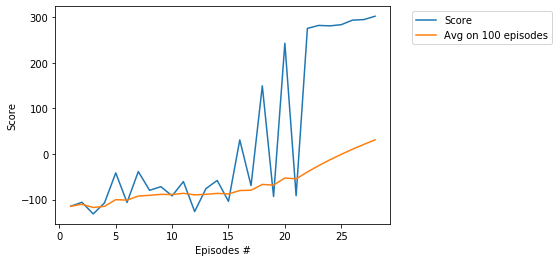

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [6]:
def play(env, agent, num_episodes):
    
    state = env.reset()
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i_episode in range(num_episodes + 1):
        
        state = env.reset()
        score = 0                    
        time_start = time.time()
        
        while True:
            
            action = agent.select_action(state, eval=True)
            env.render()
            next_state, reward, done, _ = env.step(action)
            score += reward 
            state = next_state
    
            if done:
                break
                
        s = (int)(time.time() - time_start)
        
        scores_deque.append(score)
        scores.append(score)    
        
        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60)) 
    

In [7]:
play(env=env, agent=agent, num_episodes=7)

Episode 0	Average Score: 301.05,	Score: 301.05 	Time: 00:00:22
Episode 1	Average Score: 302.79,	Score: 304.52 	Time: 00:00:17
Episode 2	Average Score: 302.37,	Score: 301.54 	Time: 00:00:18
Episode 3	Average Score: 302.17,	Score: 301.58 	Time: 00:00:18
Episode 4	Average Score: 302.05,	Score: 301.58 	Time: 00:00:18
Episode 5	Average Score: 302.15,	Score: 302.60 	Time: 00:00:17
Episode 6	Average Score: 301.96,	Score: 300.86 	Time: 00:00:17
Episode 7	Average Score: 302.05,	Score: 302.69 	Time: 00:00:18


In [8]:
env.close()